<a href="https://colab.research.google.com/github/Josiah-tan/ez_life/blob/main/ez_life/jt_property.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementation JTProperty
  - Uses EzProperty class which inherits from property
    - Currently EzProperty changes the setter function such that the return value is the value set by the setter

In [ ]:
class EzProperty(property):
  def __init__(self, *args, **kwargs):
    return super().__init__(*args, **kwargs)
  
  def setter_preprocess(self, _func):
    """
    Sets return value of _func to self._func.__name__
    """
    def wrapper(obj, val):
      setattr(obj, f"_{_func.__name__}", _func(obj, val))
    return wrapper

  def setter(self, _func):
    """
    calls setter_preprocess wrapper to alter behaviour of _func
    """
    return super().setter(self.setter_preprocess(_func))

In [ ]:
import functools
class JTProperty:
  def __init__(self, setter = False):
    self.setter = setter
  def __call__(self, _func):
    public_name = _func.__name__
    protected_name = f"_{public_name}"

    @EzProperty
    @functools.wraps(_func)
    def wrapper(obj):
      if protected_name not in dir(obj) or getattr(obj, protected_name) is None:
        # if self._name is not available atm
        if (not(self.setter)):
          setattr(obj, protected_name, _func(obj)) 
        else:
          # call setter method with the return value of the property function this effectively sets obj._name
          setattr(obj, public_name, _func(obj)) 
      return getattr(obj, protected_name)
    return wrapper

# Basic Property Demo
- prop3 is dependent upon the values of prop2 and prop 1 as shown below

In [ ]:
class PropDemo:
  def __init__(self):
    self._prop1 = None
    self._prop2 = None
    self._prop3 = None
  
  @property
  def prop1(self):
    if self._prop1 is None:
      self._prop1 = self.get_prop1()
    return self._prop1

  @property
  def prop2(self):
    if self._prop2 is None:
      self._prop2 = self.get_prop2()
    return self._prop2

  @property
  def prop3(self):
    if self._prop3 is None:
      self._prop3 = self.get_prop3()
    return self._prop3
  
  def get_prop1(self):
    return 1
  def get_prop2(self):
    return self.prop1 + 1
  def get_prop3(self):
    return self.prop2 + 1
  


In [ ]:
if __name__ == '__main__':
  prop_dem = PropDemo()
  #print(prop_dem.prop3)

- The @JTProperty decorator uses less lines of code then the @property decorator, but achieves the same result

In [ ]:
class JTPropDemo:
  def __init__(self):
    pass
  
  @JTProperty()
  def prop1(self):
    return 1

  @JTProperty()
  def prop2(self):
    return self.prop1 + 1

  @JTProperty()
  def prop3(self):
    return self.prop2 + 1
  

In [ ]:
if __name__ == '__main__':
  a_prop_dem = JTPropDemo()
  assert a_prop_dem.prop3 == prop_dem.prop3


# Setter methods
- Consider a class that uses getter and setter methods as shown below:

In [ ]:
class SetAndGet:
  def __init__(self, r = 1):
    # initialise the protected variable
    self._radius = None

    # calls the @radius.setter method
    self.radius = r
  @property
  def radius(self):
    if self._radius is None:
      self.radius = 2
    return self._radius
  @radius.setter
  def radius(self, r):
    if r <= 0:
      raise ValueError("radius should be greater than 0")
    self._radius = r

- In the test below, contextlib silences the ValueError that occurs with setting the radius to -5

In [ ]:
if __name__ == '__main__':
  import contextlib
  setandget = SetAndGet()
  #print(setandget.radius)
  rad1 = setandget.radius

  setandget.radius = 5
  #print(setandget.radius)
  rad2 = setandget.radius

  setandget.radius = 3
  #print(setandget.radius)
  rad3 = setandget.radius

  with contextlib.suppress(ValueError):
    setandget.radius = -5
  #print(setandget.radius)
  rad4 = setandget.radius

  # 1 5 3 3

- JTProperty() and .setter reduce abstraction involving usage of hidden "protected variables"
  - setter = True should be set when @radius.setter is used

In [ ]:
class JTSetAndGet:
  def __init__(self, r = 1):
    self.radius = r
  @JTProperty(setter = True)
  def radius(self):
    return 2

  @radius.setter
  def radius(self, r):
    if r <= 0:
      raise ValueError("radius should be greater than 0")
    return r


In [ ]:
if __name__ == '__main__':
  import contextlib
  setandget = SetAndGet()
  #print(setandget.radius)
  alt_rad1 = setandget.radius
  assert alt_rad1 == rad1

  setandget.radius = 5
  #print(setandget.radius)
  alt_rad2 = setandget.radius
  assert alt_rad2 == rad2

  setandget.radius = 3
  #print(setandget.radius)
  alt_rad3 = setandget.radius
  assert alt_rad3 == rad3

  with contextlib.suppress(ValueError):
    setandget.radius = -5
  #print(setandget.radius)
  alt_rad4 = setandget.radius
  assert alt_rad4 == rad4
  
  # 1 5 3 3

# Areas Of Improvement
  - Introduce setter detection to reduce uneccessary setter = True kwargs
  - Dependency graphs
    - Consider a graph as shown below:
      - if a changes, then b updates, then d updates
      - if b changes, then d updates
      - if c changes, then d updates
      - if d changes, nothin happens bro


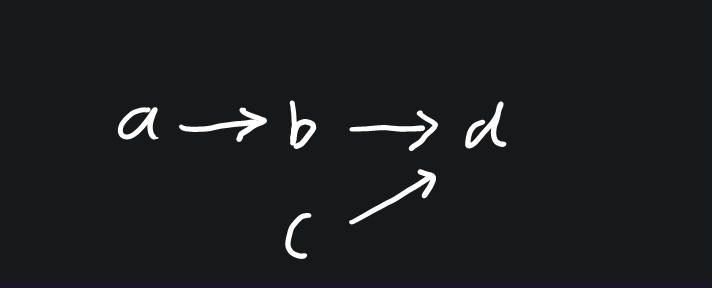